In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [2]:
stockdata=yf.download('AAPL',start='2018-01-01',end='2024-01-01')
stockdata.head()
print(stockdata.columns)

[*********************100%***********************]  1 of 1 completed

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


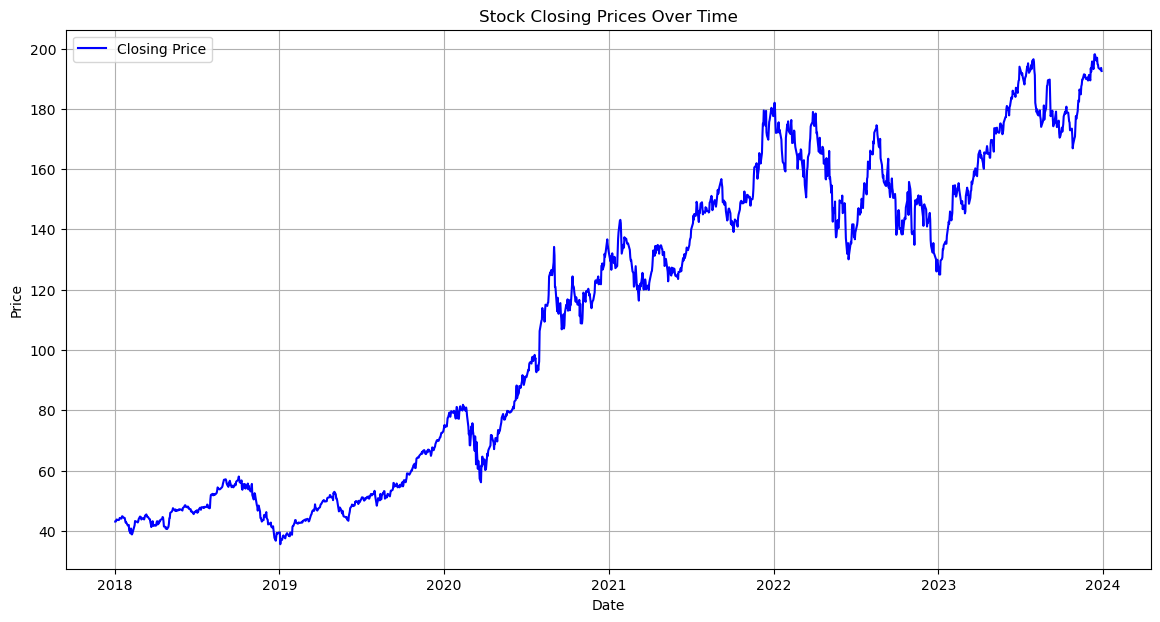

In [3]:
#visualizing the closed prices
plt.figure(figsize=(14, 7))
plt.plot(stockdata["Close"], label="Closing Price", color='blue')
plt.title("Stock Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

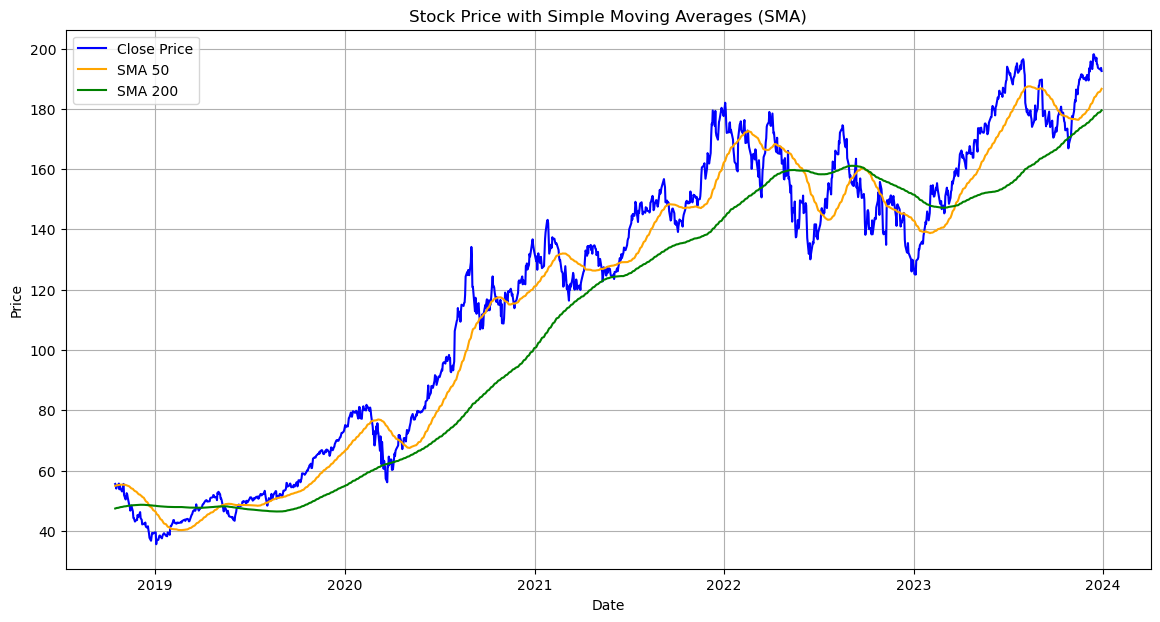

In [4]:
#calculating moving averages
stockdata["SMA_50"] = stockdata["Close"].rolling(window=50).mean()
stockdata["SMA_200"] = stockdata["Close"].rolling(window=200).mean()
stockdata.dropna(inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(stockdata["Close"], label="Close Price", color='blue')
plt.plot(stockdata["SMA_50"], label="SMA 50", color='orange')
plt.plot(stockdata["SMA_200"], label="SMA 200", color='green')
plt.title("Stock Price with Simple Moving Averages (SMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

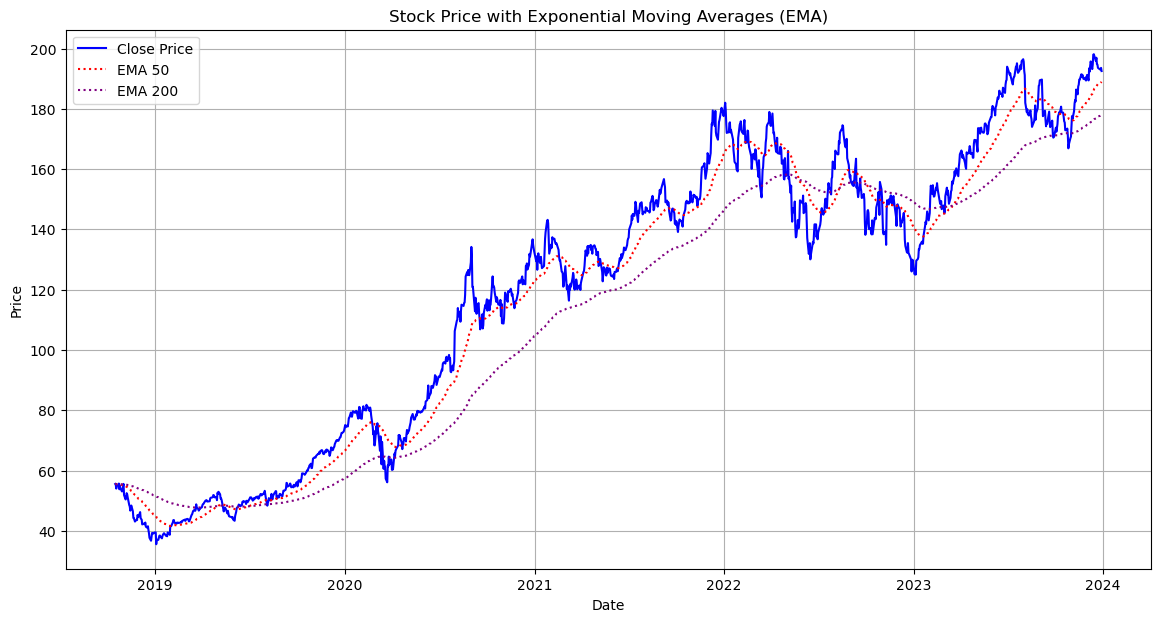

In [5]:
#calculating exponential moving averages
stockdata["EMA_50"] = stockdata["Close"].ewm(span=50,adjust=False).mean()
stockdata["EMA_200"] = stockdata["Close"].ewm(span=200,adjust=False).mean()
plt.figure(figsize=(14, 7))
plt.plot(stockdata["Close"], label="Close Price", color='blue')
plt.plot(stockdata["EMA_50"], label="EMA 50", color='red', linestyle='dotted')
plt.plot(stockdata["EMA_200"], label="EMA 200", color='purple', linestyle='dotted')
plt.title("Stock Price with Exponential Moving Averages (EMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [6]:
#calculating rsi
def RSI(DF, n=14):
    """Calculate Relative Strength Index (RSI)"""
    df = DF.copy()
    df["change"] = df["Adj Close"].diff()
    df["gain"] = df["change"].where(df["change"] > 0, 0)
    df["loss"] = -df["change"].where(df["change"] < 0, 0)
    
    df["avg_gain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    df["avg_loss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    
    # Calculate Relative Strength (RS)
    df["rs"] = df["avg_gain"] / df["avg_loss"]
    
    # Calculate RSI
    df["rsi"] = 100 - (100 / (1 + df["rs"]))
    return df[["rsi"]]
rsi=RSI(stockdata,n=14)
stockdata = pd.concat([stockdata, rsi], axis=1)
stockdata.dropna(inplace=True)

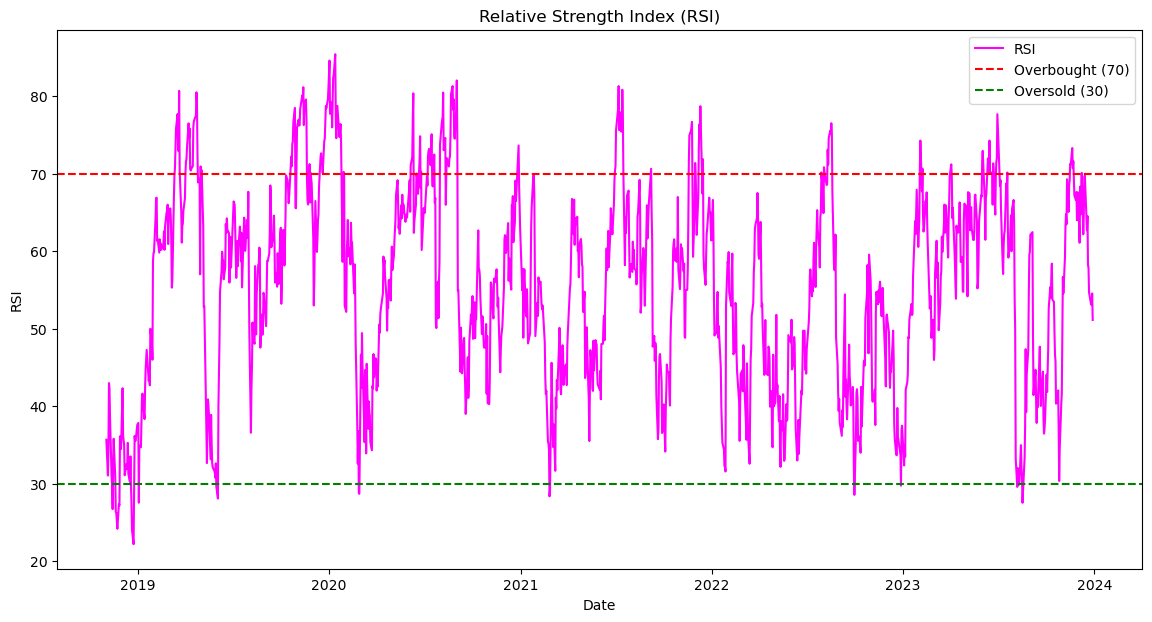

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(stockdata.index, stockdata["rsi"], label="RSI", color='magenta')
plt.axhline(70, linestyle='--', color='red', label="Overbought (70)")
plt.axhline(30, linestyle='--', color='green', label="Oversold (30)")
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.show()

In [8]:
#calculating macd
def MACD(DF, a=12, b=26, c=9):
    df = DF.copy()
    df["ma_fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    df["ma_slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    df["macd"] = df["ma_fast"] - df["ma_slow"]
    df["signal"] = df["macd"].ewm(span=c, min_periods=c).mean()
    return df[["macd", "signal"]]
stockdata[["macd", "signal"]] = MACD(stockdata)
stockdata.dropna(inplace=True)

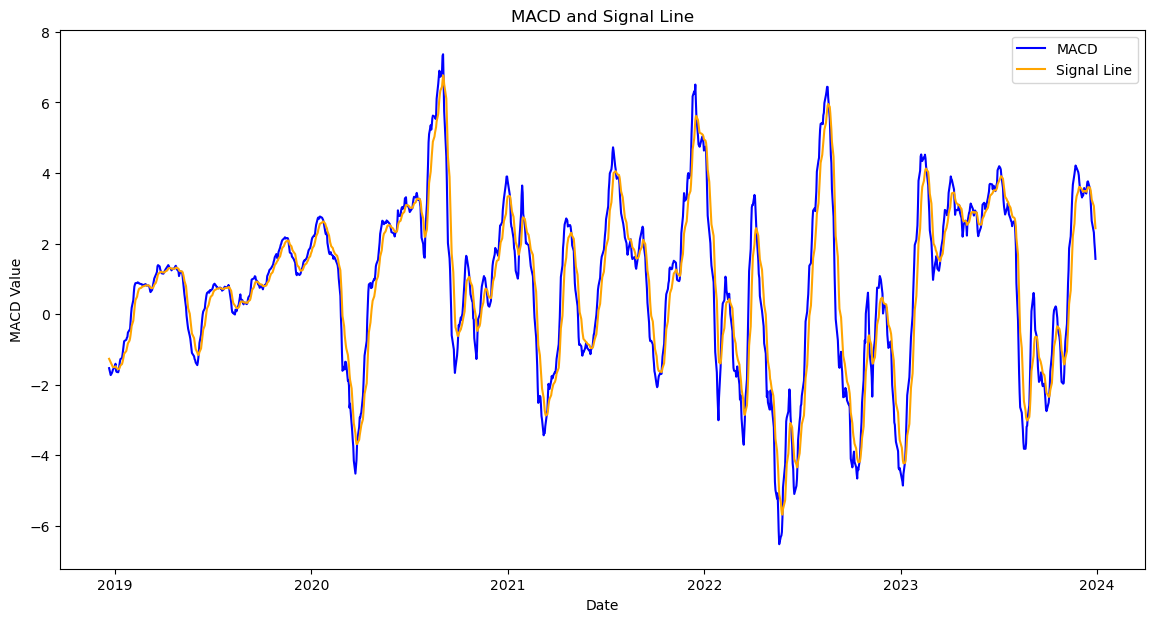

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(stockdata.index, stockdata["macd"], label="MACD", color='blue')
plt.plot(stockdata.index, stockdata["signal"], label="Signal Line", color='orange')
plt.title("MACD and Signal Line")
plt.xlabel("Date")
plt.ylabel("MACD Value")
plt.legend()
plt.show()

In [10]:
#calculating bollinger band
def Bollinger_Band(DF, n=20):
    df = DF.copy()
    df["middle_band"] = df["Adj Close"].rolling(20).mean()
    rolling_std = df["Adj Close"].rolling(20).std()
    df["upper_band"] = df["middle_band"] + 2 * rolling_std['AAPL']
    df["lower_band"] = df["middle_band"] - 2 * rolling_std['AAPL']
    df["BB_width"] = df["upper_band"] - df["lower_band"]
    return df
stockdata = Bollinger_Band(stockdata)
stockdata.dropna(inplace=True)

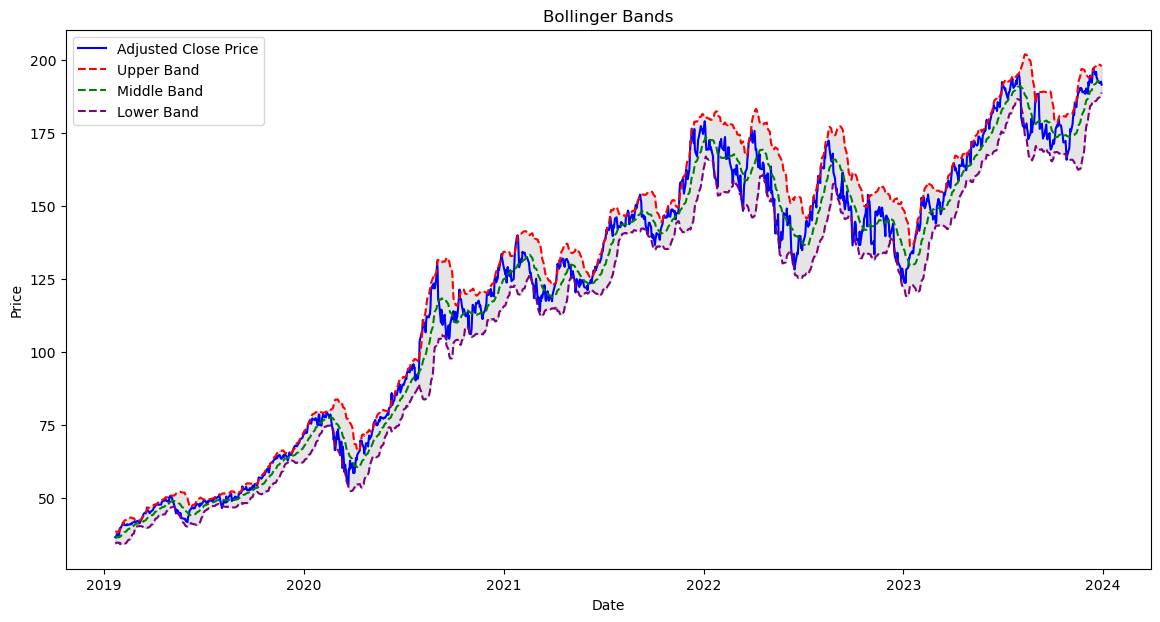

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(stockdata["Adj Close"], label="Adjusted Close Price", color='blue')
plt.plot(stockdata["upper_band"], label="Upper Band", color='red', linestyle='--')
plt.plot(stockdata["middle_band"], label="Middle Band", color='green', linestyle='--')
plt.plot(stockdata["lower_band"], label="Lower Band", color='purple', linestyle='--')
plt.fill_between(stockdata.index, stockdata["lower_band"], stockdata["upper_band"], color='grey', alpha=0.2)
plt.title("Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [12]:
#calculating ATR
def ATR(DF,n=14):
    df=DF.copy()
    df["H-L"]=df["High"]-df["Low"]
    df["H-PC"]=df["High"]-df["Adj Close"].shift(1)
    df["L-PC"]=df["Low"]-df["Adj Close"].shift(1)
    df["TR"]=df[["H-L","H-PC","L-PC"]].max(axis=1,skipna=False)
    df["ATR"]=df["TR"].ewm(span=n,min_periods=n).mean()
    return df
stockdata=ATR(stockdata)
stockdata.dropna(inplace=True)

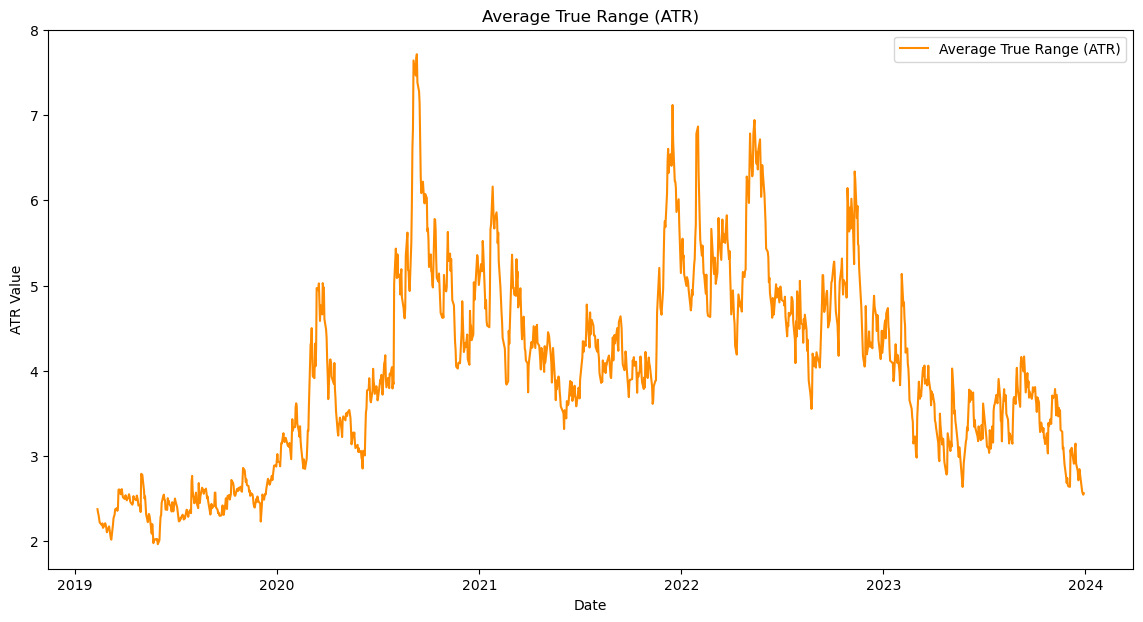

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(stockdata.index, stockdata["ATR"], label="Average True Range (ATR)", color='darkorange')
plt.title("Average True Range (ATR)")
plt.xlabel("Date")
plt.ylabel("ATR Value")
plt.legend()
plt.show()

In [14]:
#feature engineering
def prepare_data(data, lookback=30):
    features = ["Close", "SMA_50", "SMA_200", "EMA_50", "EMA_200", "rsi", "macd", "signal", "upper_band", "lower_band", "BB_width", "ATR"]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i][0])  # Predicting "Close"
    X, y = np.array(X), np.array(y)
    return X, y, scaler

In [15]:
# --- Step 8: Model Building ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")
    return model

In [16]:
# --- Step 9: Training the Model ---
def train_model(X_train, y_train, X_val, y_val):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
    model.save("lstm_model.h5")
    return model, history

In [17]:
def test_model(model, X_val, y_val, scaler):
    y_pred = model.predict(X_val)
    y_val_unscaled = scaler.inverse_transform(np.hstack([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))]))[:, 0]
    y_pred_unscaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((y_pred.shape[0], X_val.shape[2] - 1))]))[:, 0]

    mae = mean_absolute_error(y_val_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_val_unscaled, y_pred_unscaled)
    r2 = r2_score(y_val_unscaled, y_pred_unscaled)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-Squared (R2): {r2}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_unscaled, label="Actual Price")
    plt.plot(y_pred_unscaled, label="Predicted Price")
    plt.title("Actual vs Predicted Stock Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

C:\Users\HP\anaconda3\envs\quant\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.7814 - val_loss: 0.0034
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0101 - val_loss: 0.0190
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0043 - val_loss: 0.0126
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0057 - val_loss: 7.7295e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0044 - val_loss: 9.7471e-04
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0034 - val_loss: 0.0135
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Mean Absolute Error (MAE): 3.3049530381264765
Mean Squared Error (MSE): 15.097990016123088
R-Squared (R2): 0.9284219205976904


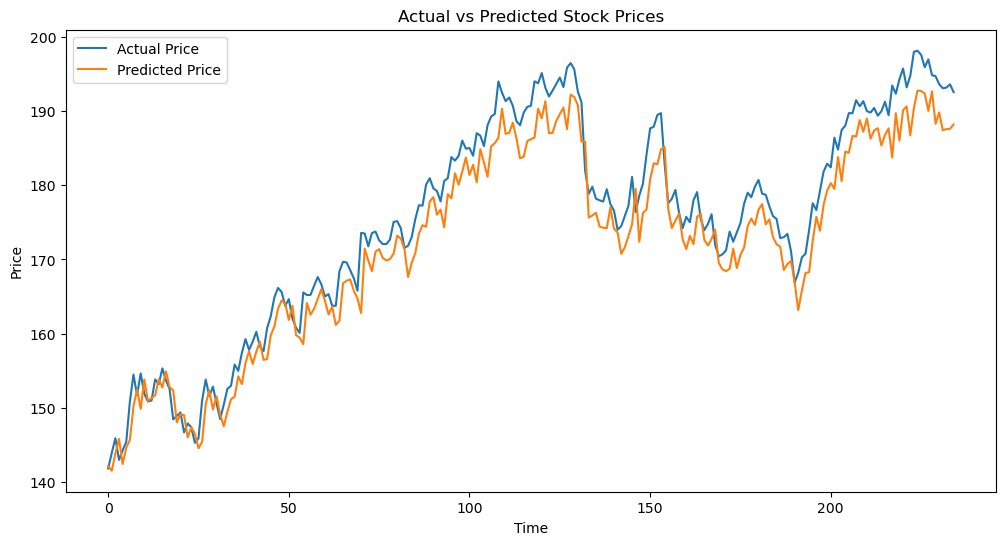

In [18]:
# --- Main Execution ---
if __name__ == "__main__":
    
    # Step 3: Prepare Data
    lookback = 60
    X, y, scaler = prepare_data(stockdata, lookback)

    # Step 4: Split Data
    train_size = int(0.8 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    # Step 5: Train Model
    model, history = train_model(X_train, y_train, X_val, y_val)

    # Step 6: Test Model
    test_model(model, X_val, y_val, scaler)